In [94]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import math
import random
import pickle
import itertools

In [95]:
t = time.time()

# Load preprocessed data
# train_X = bp.unpack_ndarray_file('preprocessed/train_data.bp')
# train_y = bp.unpack_ndarray_file('preprocessed/train_labels.bp')
# train_kernel = bp.unpack_ndarray_file('preprocessed/train_spm_dist_mat.bp')
# test_X = bp.unpack_ndarray_file('preprocessed/%(stack)s_test_data.bp' % {'stack': 'MD585'})
train_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_data.bp')
train_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_labels.bp')
train_kernel = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_spm_dist_mat.bp')
train_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_fnames.bp')
test_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/%(stack)s_test_data.bp' % {'stack': 'MD585'})
test_fcoords = bp.unpack_ndarray_file('sift-jpeg/preprocessed/%(stack)s_test_fcoords.bp' % {'stack': 'MD585'})

sys.stderr.write('Load time: %f seconds\n' % (time.time() - t)) # ~ 2s / 12k training data

Load time: 0.857168 seconds


In [96]:
class Hypersphere_abstain:
    
    def __init__(self, center, radius, threshold, label, alpha, acc, unweighted_acc,
                 label_distribution, center_index, neighbor_indices):
        
        self.center = center
        self.radius = radius
        self.thres = threshold
        self.label = label
        self.alpha = alpha
        self.acc = acc # Weighted accuracy
        self.unweighted_acc = unweighted_acc
        self.label_distribution = label_distribution # Prediction for M2
        self.center_index = center_index
        self.neighbor_indices = neighbor_indices
        
class WeakLearner_generator:
    
    def __init__(self, init_radius, abstain_thres, err_thres, growth_radius):
        
        self.init_radius = init_radius
        self.abstain_thres = abstain_thres
        self.err_thres = err_thres
        self.growth_radius = growth_radius
    
    def generate(self, train_X, train_y, train_kernel, D, n_class):
        
        n_samples = train_X.shape[0]

        # Choose an exemplar
        exemplar_index = np.random.choice(range(n_samples), p=D.tolist())
        exemplar = train_X[exemplar_index]

        # Retrieve scores to exemplar and sort
        scores = train_kernel[exemplar_index]
        sorted_scores = np.sort(scores)[::-1]
        sorted_indices = np.argsort(scores)[::-1]
        # sorted_X = train_X[sorted_indices]
        sorted_y = train_y[sorted_indices].astype('int64')
        sorted_D = D[sorted_indices]

        # Calculate plurarity and percentage of initial sphere
        count = np.bincount(sorted_y[:self.init_radius],
                            weights=sorted_D[:self.init_radius],
                            minlength=n_class)
        unweighted_count = np.bincount(sorted_y[:self.init_radius],
                                       minlength=n_class)
        y_of_interest = np.argmax(count)
        percentage = count[y_of_interest]*1.0 / np.sum(sorted_D[:self.init_radius])

        # Abstain test (HACK to avoid zero threshold)
        if percentage<self.abstain_thres or np.sum(sorted_scores)==0.0:
            return None, None

        # Caculate best radius
        index_of_interest = np.array([y_==y_of_interest for y_ in sorted_y])
        weight_of_interest = np.cumsum(index_of_interest*sorted_D)
        best_radius = self.init_radius
        best_percentage = percentage
        for i in range(self.init_radius+self.growth_radius, n_samples, self.growth_radius):
            perc = weight_of_interest[i-1]*1.0 / np.sum(sorted_D[:i])
            if perc>best_percentage:
                best_radius = i
                best_percentage = perc

        # Calculate alpha
        w_total = np.sum(sorted_D[:best_radius])
        w_acc = weight_of_interest[best_radius-1]*1.0 / w_total
        w_err = 1.0 - w_acc
        epsilon = 1.0e-10
        alpha = 0.5 * math.log((w_acc+epsilon)/(w_err+epsilon))
        
        # Error test
        if w_err>self.err_thres:
            return None, None

        # Return weakleaner
        acc = np.sum(index_of_interest[:best_radius])*1.0 / best_radius
        threshold = sorted_scores[best_radius-1]
        label_distribution = np.bincount(sorted_y[:best_radius], minlength=n_class)
        h = Hypersphere_abstain(exemplar, best_radius, threshold, y_of_interest,
                                alpha, w_acc, acc, label_distribution,
                                exemplar_index, sorted_indices)
        
        return h, index_of_interest


In [97]:
# Adaboost.M1

class Adaboost_M1:
    
    def __init__(self, iterations, n_class, weaklearner):
        
        self.T = iterations
        self.H = []
        self.D = None
        self.n_class = n_class
        self.weaklearner = weaklearner
    
    def train(self, train_X, train_y, train_kernel):
        
        n_samples = train_X.shape[0]
        self.D = (1.0/n_samples) * np.ones((n_samples, ))

        for t in xrange(self.T):

            if t%100==0:
                print 't: ', t
                
            # Generate weaklearner
            h, index_of_interest = \
                self.weaklearner.generate(train_X, train_y, train_kernel, self.D, self.n_class)
            
            # Check abstained
            if not h:
                continue
                
            self.H.append(h)

            # Reweight
            index_of_other = ~index_of_interest
            self.D[h.neighbor_indices] = self.D[h.neighbor_indices] * \
                                        (index_of_other*1.0 + index_of_interest*math.exp(-1.0*h.alpha))

            # Normalize
            self.D = self.D*1.0 / np.sum(self.D)
            
        print 'Num classifiers: ', len(self.H)

    def predict_with_kernel(self, train_X, train_y, train_kernel):

        n_samples = train_kernel.shape[1]
        staged_pred_y = np.zeros((len(self.H), n_samples)).astype('int64')
        print 'n: ', n_samples

        for i in xrange(1, len(self.H)+1):

            classifiers = self.H[:i]
            prob = np.zeros((n_samples, self.n_class))
            
            for clf in classifiers:
                score = np.copy(train_kernel[clf.center_index])
                score[score < clf.thres] = 0.0 #Predict as not clf.label
                score[score >= clf.thres] = clf.alpha #Predict as clf.label
                prob[:, clf.label] += score

            max_prob = np.max(prob, axis=1)
            pred_y = np.argmax(prob, axis=1)
            pred_y[max_prob==0.0] = 0
            staged_pred_y[i-1,:] = pred_y

        print 'Correct predictions: ', np.sum(train_y==staged_pred_y[-1])
        
        return staged_pred_y
    
    def predict_without_kernel(self, test_X):
        
        n_samples = test_X.shape[0]
        n_clfs = len(self.H)
        staged_pred_y = np.zeros((n_clfs, n_samples)).astype('int64')
        print 'n: ', n_samples
        
        
        def compute_intersection_kernel_oneJob(i):
            dist = np.minimum(self.H[i].center, test_X)
            dist = np.sum(dist, axis=1).reshape((1, n_samples))
            return dist

        score_kernel = np.concatenate([compute_intersection_kernel_oneJob(i) for i in xrange(n_clfs)], axis=0)
        print 'Test kernel shape: ', score_kernel.shape

        for i in xrange(1, n_clfs+1):
            
            classifiers = self.H[:i]
            prob = np.zeros((n_samples, self.n_class))
            
            for (c, clf) in zip(range(i), classifiers):
                score = np.copy(score_kernel[c])
                score[score < clf.thres] = 0.0 #Predict as not clf.label
                score[score >= clf.thres] = clf.alpha #Predict as clf.label
                prob[:, clf.label] += score
            
            max_prob = np.max(prob, axis=1)
            pred_y = np.argmax(prob, axis=1)
            pred_y[max_prob==0.0] = 0
            staged_pred_y[i-1,:] = pred_y
        
        return staged_pred_y

In [98]:
t = time.time()

# Setup
weak = WeakLearner_generator(init_radius=50, 
                             abstain_thres=0.5,
                             err_thres=0.5,
                             growth_radius=10)
ada = Adaboost_M1(iterations=2000, 
                  n_class=16, 
                  weaklearner=weak)

sys.stderr.write('Setup time: %f seconds\n' % (time.time() - t)) # ~ 2s / 12k training data

Setup time: 0.000210 seconds


In [99]:
# Train

t = time.time()
ada.train(train_X, train_y, train_kernel)
sys.stderr.write('Train time: %f seconds\n' % (time.time() - t)) # ~ 15s / 12k training data

t:  0
t:  100
t:  200
t:  300
t:  400
t:  500
t:  600
t:  700
t:  800
t:  900
t:  1000
t:  1100
t:  1200
t:  1300
t:  1400
t:  1500
t:  1600
t:  1700
t:  1800
t:  1900
Num classifiers:  64


Train time: 1.061680 seconds


In [100]:
print 'Labels: ', set([h.label for h in ada.H])

Labels:  set([2, 5, 6, 7, 8, 9, 13, 14, 15])


In [101]:
# Predict train

t = time.time()
staged_pred_y = ada.predict_with_kernel(train_X, train_y, train_kernel)
sys.stderr.write('Test time: %f seconds\n' % (time.time() - t)) # ~ 12s / 12k training data

n:  1500
Correct predictions:  448


Test time: 0.082466 seconds


In [102]:
final_y = staged_pred_y[-1]
print 'Label 0: ', np.sum(final_y==0)
print 'Labels: ', set(final_y)

Label 0:  759
Labels:  set([0, 2, 5, 6, 7, 8, 9, 13, 14, 15])


In [103]:
# Predict test

t = time.time()
staged_pred_test_y = ada.predict_without_kernel(test_X)
sys.stderr.write('Test time: %f seconds\n' % (time.time() - t)) # ~ s / 12k training data

n:  20979
Test kernel shape:  (64, 20979)


Test time: 35.622292 seconds


In [104]:
# Calculate true positive and abstain rate

train_tp=[]
train_abstain_rate = []
n_training = len(staged_pred_y[0])
for pred_y in staged_pred_y:
    n_abstain = np.sum(pred_y==0)
    n_tp_total = np.sum(pred_y!=0)
    n_tp_correct = np.sum(np.logical_and(pred_y!=0,pred_y==train_y))
    train_tp.append(1.0 * n_tp_correct / n_tp_total)
    train_abstain_rate.append(1.0 * n_abstain / n_training)

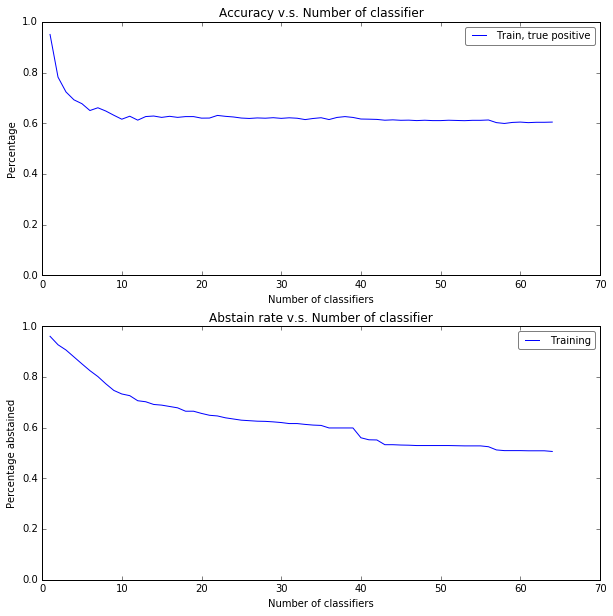

In [105]:
# Plot true positive and abstain rate

n_clf = len(ada.H);
plt.figure(figsize=(10,10));
plt.subplot(211);
plt.title("Accuracy v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage");
plt.ylim([0.0, 1.0]);
plt.plot(range(1, n_clf + 1), train_tp, label='Train, true positive');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
# plt.hlines(0.6, 0, n_clf, linestyles=':', color='grey');
# plt.hlines(0.7, 0, n_clf, linestyles=':', color='grey');

plt.subplot(212);
plt.title("Abstain rate v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage abstained");
plt.ylim([0.0, 1.0]);
plt.plot(range(1, n_clf + 1), train_abstain_rate, label='Training');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
# plt.hlines(0.8, 0, n_clf, linestyles=':', color='grey');

[ 0  0  0  0  0  0  0  0  3  0  0  0  0  0 57  0]
[ 0  3 29  0  1  3  0  0  0  1  0  0  2  0  0 11]
[ 0  1 33  0  0  0  0  0  0  3  2  2  2  0  0  7]
[ 0  0  0  0  0  7  0  0 10  0  0  0  0 24  9  0]
[ 0  0  0  2  5  2  2  1  1  0  1  4  0 32  0  0]
[ 0  2  0  1  2  8  6  1 27  1  0  0  0  0  2  0]
[ 0  0  1  0 10  0  0  0  1  0  3  1  0  6  0 28]
[ 0  3  0  4  2  4  5 25  1  2  1  2  1  0  0  0]
[ 0  2  0  3  2  3  5 26  0  3  2  3  1  0  0  0]
[ 0  0  0  4  2  7  0  0  3  2  0  2  0 29  1  0]
[ 0  0  0  0  0  0  0  0  2  0  0  0  0  0 48  0]
[ 0  1  0  5  1  5  1 26  0  2  0  2  2  5  0  0]
[ 0  1  0  1  0 10  1  0 20  0  0  0  0  2 15  0]
[ 0  1 32  0  1  0  0  0  0  3  1  0  1  0  0 11]
[ 0  0  0  0  0  4  0  0  5  0  0  0  0 16 25  0]
[ 0  0  0  0  0 11  1  0 28  0  1  1  0  7 11  0]


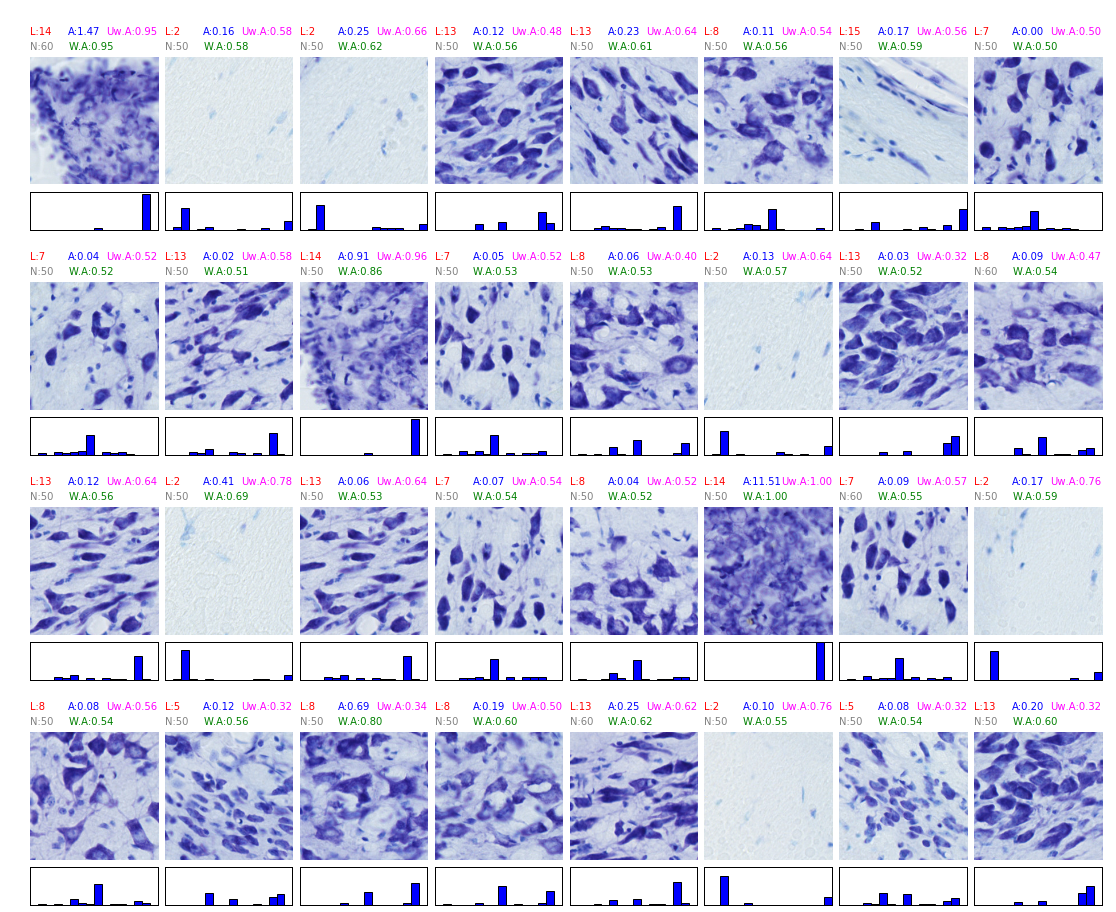

In [106]:
# Example hyperspheres

for i in xrange(16):
    print ada.H[i].label_distribution

subplot_width = 2.4;
subplot_height = 4;
fig_row = 4;
fig_col = 8;
plt.figure(figsize=(subplot_width * fig_col, subplot_height * fig_row));
plt.title('Information of hypersphere: (label, alpha, radius, number of examples)');
for row in range(0, fig_row):
    for col in range(0, fig_col):
        i = row * fig_col + col;
        ax0 = plt.subplot2grid((5 * fig_row, 3 * fig_col), (5 * row, 3 * col), colspan=3);
        ax0.text(0.0, 0.4, 'L:{}'.format(ada.H[i].label), fontsize=10, color='red');
        ax0.text(0.0, 0.0, 'N:{}'.format(ada.H[i].radius), fontsize=10, color='grey');
        ax0.text(0.3, 0.4, 'A:{:.2f}'.format(ada.H[i].alpha), fontsize=10, color='blue');
        ax0.text(0.6, 0.4, 'Uw.A:{:.2f}'.format(ada.H[i].unweighted_acc), fontsize=10, color='magenta');
        ax0.text(0.3, 0.0, 'W.A:{:.2f}'.format(ada.H[i].acc), fontsize=10, color='green');
        ax0.axison=False;
        
        img=imread(train_fnames[ada.H[i].center_index]);
        ax1 = plt.subplot2grid((5 * fig_row, 3 * fig_col), (5 * row + 1, 3 * col), rowspan=3, colspan=3);
        ax1.imshow(img, cmap=plt.cm.gray);
        ax1.axis('off');
        ax2 = plt.subplot2grid((5 * fig_row, 3 * fig_col), (5 * row + 4, 3 * col), colspan=3);
        ax2.bar(np.arange(0, 16), ada.H[i].label_distribution*1.0/sum(ada.H[i].label_distribution), width=1);
        ax2.axes.get_yaxis().set_visible(False);
        ax2.axes.get_xaxis().set_visible(False);
        ax2.axes.set_ylim([0.0, 1.0]);

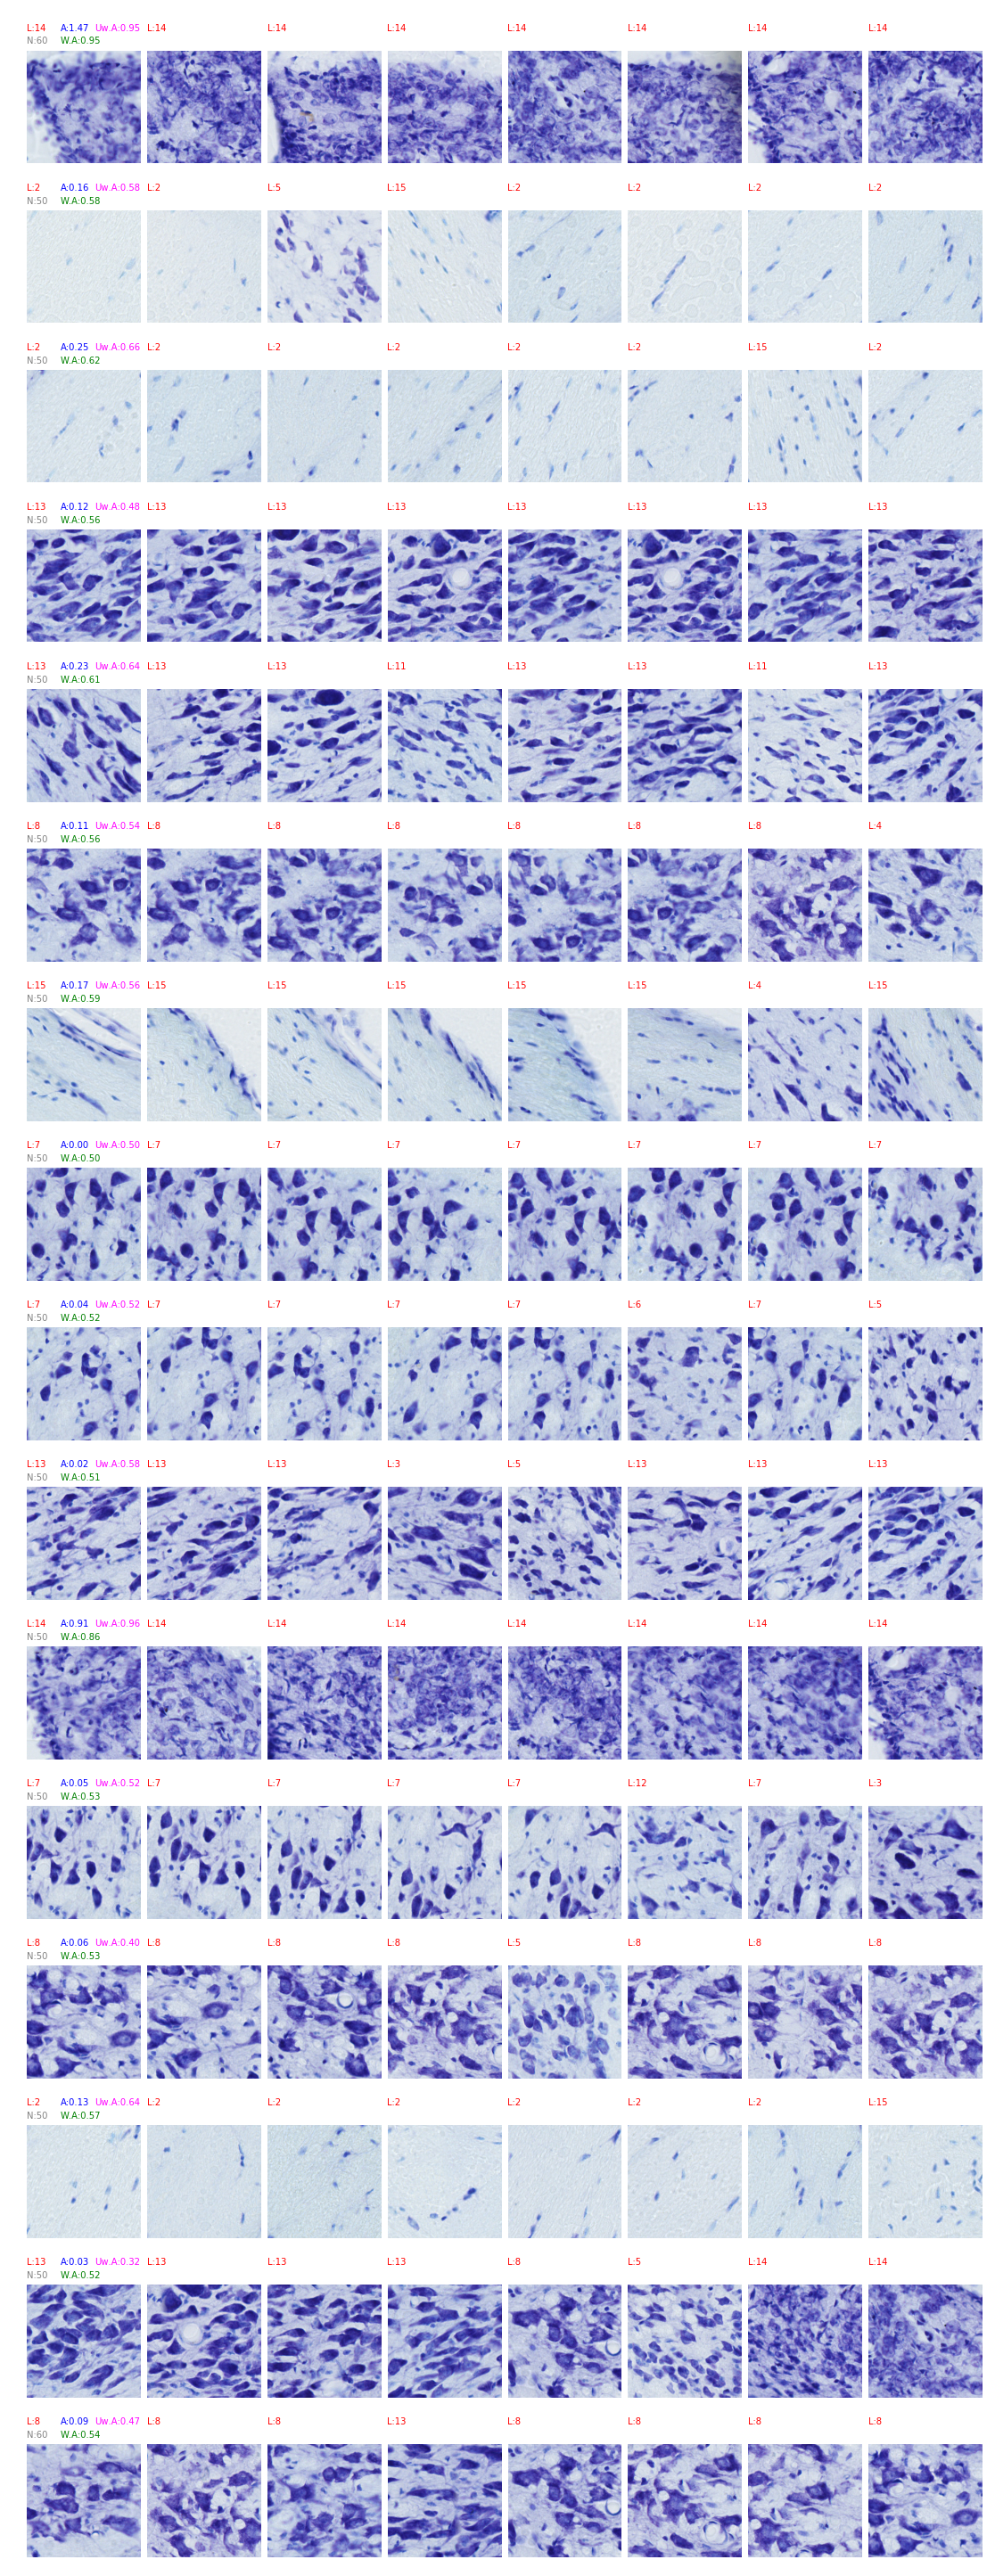

In [110]:
# Example hypersphere centers and their closest neighbors

subplot_width = 2.4;
subplot_height = 3.2;
fig_row = 16;
fig_col = 8;
plt.figure(figsize=(subplot_width * fig_col, subplot_height * fig_row));
for h in xrange(fig_row):
    for n in xrange(fig_col):
        ax0 = plt.subplot2grid((4 * fig_row, 3 * fig_col), (4 * h, 3 * n), colspan=3);
        
        if n==0:
            ax0.text(0.0, 0.4, 'L:{}'.format(ada.H[h].label), fontsize=10, color='red');
            ax0.text(0.0, 0.0, 'N:{}'.format(ada.H[h].radius), fontsize=10, color='grey');
            ax0.text(0.3, 0.4, 'A:{:.2f}'.format(ada.H[h].alpha), fontsize=10, color='blue');
            ax0.text(0.6, 0.4, 'Uw.A:{:.2f}'.format(ada.H[h].unweighted_acc), fontsize=10, color='magenta');
            ax0.text(0.3, 0.0, 'W.A:{:.2f}'.format(ada.H[h].acc), fontsize=10, color='green');
        else:
            ax0.text(0.0, 0.4, 'L:{}'.format(int(train_y[ada.H[h].neighbor_indices[n]])), fontsize=10, color='red');
        ax0.axison=False;
        
        img=imread(train_fnames[ada.H[h].neighbor_indices[n]]);
        ax1 = plt.subplot2grid((4 * fig_row, 3 * fig_col), (4 * h + 1, 3 * n), rowspan=3, colspan=3);
        ax1.imshow(img, cmap=plt.cm.gray);
        ax1.axis('off');